In [1]:
import os
from xml.dom.pulldom import default_bufsize
from dotenv import load_dotenv
import duckdb
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
load_dotenv()
# conn = duckdb.connect(':memory:')
conn = duckdb.connect("citi_bike.duckdb")
conn.execute("PRAGMA threads=8;")
conn.execute("PRAGMA enable_print_progress_bar;")
conn.execute("SET preserve_insertion_order = false;")
conn.execute('INSTALL httpfs;')
conn.execute('LOAD httpfs;')
# authenication
conn.execute(f"SET s3_region='us-east-1';")
conn.execute(f"SET s3_access_key_id='{os.environ['AWS_ACCESS_KEY_ID']}';")
conn.execute(f"SET s3_secret_access_key='{os.environ['AWS_SECRET_ACCESS_KEY']}';")

In [3]:
nyc_year_range = range(2013,2026)
jc_year_range = range(2015,2026)

In [4]:
from random import sample

'''
nyc_schema_cols_1 = [
    "trip_duration",
    # "trip_date",
    "start_time",
    "stop_time",
    "start_station_id",
    "start_station_name",
    "start_station_lat",
    "start_station_long",
    "end_station_id",
    "end_station_name",
    "end_station_lat",
    "end_station_long",
    "user_type"
]
nyc_schema_cols_2 = [
    'start_time',
    'stop_time', 
    'start_station_name', 
    'start_station_id', 
    'end_station_name', 
    'end_station_id', 
    'start_station_lat', 
    'start_station_long', 
    'end_station_lat', 
    'end_station_long',
    'user_type'
]
jc_schema_cols_1 = [
    'trip_duration',
    'start_time',
    'stop_time',
    'start_station_id',
    'start_station_name',
    'start_station_lat',
    'start_station_long',
    'end_station_id',
    'end_station_name',
    'end_station_lat',
    'end_station_long',
    'user_type'
]
jc_schema_cols_2 = [
    'start_time',
    'stop_time',
    'start_station_name',
    'start_station_id',
    'end_station_name',
    'end_station_id',
    'start_station_lat',
    'start_station_long',
    'end_station_lat',
    'end_station_long',
    'user_type',
]

schema_cols_map = {"nyc": {"2013":nyc_schema_cols_1, "2014":nyc_schema_cols_1, "2015":nyc_schema_cols_1, "2016":nyc_schema_cols_1, "2017":nyc_schema_cols_1, "2018":nyc_schema_cols_1, "2019":nyc_schema_cols_1, "2020":nyc_schema_cols_2, "2021":nyc_schema_cols_2, "2022":nyc_schema_cols_2, "2023":nyc_schema_cols_2, "2024":nyc_schema_cols_2, "2025":nyc_schema_cols_2},
            "jc": {"2015": jc_schema_cols_1, "2016": jc_schema_cols_1, "2017": jc_schema_cols_1, "2018": jc_schema_cols_1, "2019": jc_schema_cols_1, "2020": jc_schema_cols_1, "2021": jc_schema_cols_2, "2022": jc_schema_cols_2, "2023": jc_schema_cols_2, "2024": jc_schema_cols_2, "2025": jc_schema_cols_2}}
'''
         
def assert_schema_and_dtypes(all_cols):
    target_schema = {
        "trip_duration" : "BIGINT",
        "trip_date" : "DATE",
        "start_time" : "TIMESTAMP",
        "stop_time" : "TIMESTAMP",
        "start_station_id" : "VARCHAR",
        "start_station_name" : "VARCHAR",
        "start_station_lat" : "DOUBLE",
        "start_station_long" : "DOUBLE",
        "end_station_id" : "VARCHAR",
        "end_station_name" : "VARCHAR",
        "end_station_lat" : "DOUBLE",
        "end_station_long" : "DOUBLE",
        "user_type" : "VARCHAR",
        "rideable_type" : "VARCHAR"
    }
    sample_schema = {col_name:col_type for col_name,col_type in all_cols}
    assert len(target_schema) == len(sample_schema), f"Expected {len(target_schema)} cols, Got {len(sample_schema)} cols"
    for canonical_name,canonical_dtype in target_schema.items():
        assert canonical_name in sample_schema, f"provided schema is missing {canonical_name}"
        assert sample_schema[canonical_name] == canonical_dtype, f"datatype mismatch, expected {canonical_name} -> {canonical_dtype}, got {canonical_name} -> {sample_schema[canonical_name]}"
    

In [5]:
col_mapping = {"nyc": {"2013" : {"col_names" : ["tripduration AS trip_duration","CAST(REPLACE(starttime, '\"', '') AS TIMESTAMP) AS start_time","CAST(REPLACE(SPLIT_PART(CAST(starttime AS VARCHAR),' ',1),'\"','') AS DATE) AS trip_date","CAST(REPLACE(stoptime,'\"','') AS TIMESTAMP) AS stop_time", 'CAST("start station id" AS VARCHAR) AS start_station_id','"start station name" AS start_station_name','"start station latitude" AS start_station_lat','"start station longitude" AS start_station_long','CAST("end station id" AS VARCHAR) AS end_station_id','"end station name" AS end_station_name','"end station latitude" AS end_station_lat','"end station longitude" AS end_station_long','usertype AS user_type','CAST(NULL AS VARCHAR) AS rideable_type'], 
                                     "filter_clause" : 'WHERE starttime IS NOT NULL AND stoptime IS NOT NULL AND "start station id" IS NOT NULL AND "start station latitude" IS NOT NULL AND "start station longitude" IS NOT NULL AND "end station id" IS NOT NULL AND "end station latitude" IS NOT NULL AND "end station longitude" IS NOT NULL'},
                           "2014" : {"col_names" : ["tripduration AS trip_duration","CAST(TRY_STRPTIME(starttime, ['%m/%d/%Y %H:%M:%S','%Y-%m-%d %H:%M:%S']) AS TIMESTAMP) AS start_time","CAST(TRY_STRPTIME(starttime,['%m/%d/%Y %H:%M:%S','%Y-%m-%d %H:%M:%S']) AS DATE) as trip_date","TRY_STRPTIME(stoptime,['%m/%d/%Y %H:%M:%S','%Y-%m-%d %H:%M:%S']) AS stop_time", 'CAST("start station id" AS VARCHAR) AS start_station_id','"start station name" AS start_station_name','"start station latitude" AS start_station_lat','"start station longitude" AS start_station_long','CAST("end station id" AS VARCHAR) AS end_station_id','"end station name" AS end_station_name','"end station latitude" AS end_station_lat','"end station longitude" AS end_station_long','usertype AS user_type','CAST(NULL AS VARCHAR) AS rideable_type'],
                                    "filter_clause" : ""},
                           "2015" : {"col_names" : ["tripduration AS trip_duration","CAST(TRY_STRPTIME(starttime, ['%m/%d/%Y %H:%M:%S','%m/%d/%Y %H:%M','%m/%d/%Y %H:%M:%S']) AS TIMESTAMP) AS start_time","CAST(TRY_STRPTIME(starttime,['%m/%d/%Y %H:%M','%m/%d/%Y %H:%M:%S']) AS DATE) AS trip_date","CAST(TRY_STRPTIME(stoptime,['%m/%d/%Y %H:%M:%S','%m/%d/%Y %H:%M']) AS TIMESTAMP) AS stop_time", 'CAST("start station id" AS VARCHAR) AS start_station_id','"start station name" AS start_station_name','"start station latitude" AS start_station_lat','"start station longitude" AS start_station_long','CAST("end station id" AS VARCHAR) AS end_station_id','"end station name" AS end_station_name','"end station latitude" AS end_station_lat','"end station longitude" AS end_station_long','usertype AS user_type','CAST(NULL AS VARCHAR) AS rideable_type'],
                                     "filter_clause" : ""},
                           "2016" : {"col_names" : ["tripduration AS trip_duration","CAST(TRY_STRPTIME(starttime,['%m/%d/%Y %H:%M:%S','%Y-%m-%d %H:%M:%S']) AS TIMESTAMP) AS start_time","CAST(TRY_STRPTIME(starttime,['%m/%d/%Y %H:%M:%S','%Y-%m-%d %H:%M:%S']) AS DATE) AS trip_date","CAST(TRY_STRPTIME(stoptime,['%m/%d/%Y %H:%M:%S','%Y-%m-%d %H:%M:%S']) AS TIMESTAMP) AS stop_time", 'CAST("start station id" AS VARCHAR) AS start_station_id','"start station name" AS start_station_name','"start station latitude" AS start_station_lat','"start station longitude" AS start_station_long','CAST("end station id" AS VARCHAR) AS end_station_id','"end station name" AS end_station_name','"end station latitude" AS end_station_lat','"end station longitude" AS end_station_long','usertype AS user_type','CAST(NULL AS VARCHAR) AS rideable_type'], 
                                     "filter_clause" : ""},
                           "2017" : {"col_names" : ["tripduration AS trip_duration","CAST(starttime AS TIMESTAMP) AS start_time","CAST(starttime AS DATE) as trip_date","CAST(stoptime AS TIMESTAMP) AS stop_time", 'CAST("start station id" AS VARCHAR) AS start_station_id','"start station name" AS start_station_name','"start station latitude" AS start_station_lat','"start station longitude" AS start_station_long','CAST("end station id" AS VARCHAR) AS end_station_id','"end station name" AS end_station_name','"end station latitude" AS end_station_lat','"end station longitude" AS end_station_long','usertype AS user_type','CAST(NULL AS VARCHAR) AS rideable_type'],
                                    "filter_clause" : 'WHERE "start station latitude" IS NOT NULL AND "end station latitude" IS NOT NULL AND "end station longitude" IS NOT NULL'},
                           "2018" : {"col_names" : ["tripduration AS trip_duration","CAST(REPLACE(starttime,'\"','') AS TIMESTAMP) AS start_time","CAST(REPLACE(starttime,'\"','') AS DATE) as trip_date","CAST(REPLACE(stoptime,'\"','') AS TIMESTAMP) AS stop_time", 'CAST("start station id" AS VARCHAR) AS start_station_id','"start station name" AS start_station_name','"start station latitude" AS start_station_lat','"start station longitude" AS start_station_long','CAST("end station id" AS VARCHAR) AS end_station_id','"end station name" AS end_station_name','"end station latitude" AS end_station_lat','"end station longitude" AS end_station_long','usertype AS user_type','CAST(NULL AS VARCHAR) AS rideable_type'],
                                    "filter_clause" : 'WHERE "start station id" IS NOT NULL AND "end station id" IS NOT NULL'},
                           "2019" : {"col_names" : ["tripduration AS trip_duration","CAST(starttime AS TIMESTAMP) AS start_time","CAST(starttime AS DATE) AS trip_date","CAST(stoptime AS TIMESTAMP) AS stop_time", 'CAST("start station id" AS VARCHAR) AS start_station_id','"start station name" AS start_station_name','"start station latitude" AS start_station_lat','"start station longitude" AS start_station_long','CAST("end station id" AS VARCHAR) AS end_station_id','"end station name" AS end_station_name','"end station latitude" AS end_station_lat','"end station longitude" AS end_station_long','usertype AS user_type','CAST(NULL AS VARCHAR) AS rideable_type'],
                                    "filter_clause" : 'WHERE "start station id" IS NOT NULL AND "end station id" IS NOT NULL'},
                           "2020" : {"col_names" : ["CAST(started_at AS TIMESTAMP) AS start_time","CAST(ended_at AS TIMESTAMP) AS stop_time","CAST(started_at AS DATE) AS trip_date","CAST(EXTRACT(EPOCH FROM (CAST(ended_at AS TIMESTAMP) - CAST(started_at AS TIMESTAMP))) AS BIGINT) AS trip_duration","start_station_name","CAST(start_station_id AS VARCHAR) AS start_station_id","end_station_name","end_station_id","start_lat AS start_station_lat","start_lng AS start_station_long","end_lat AS end_station_lat","end_lng AS end_station_long","member_casual AS user_type","rideable_type"],
                                     "filter_clause" : "WHERE start_station_id IS NOT NULL AND end_lat IS NOT NULL"},
                           "2021" : {"col_names" : ["CAST(started_at AS TIMESTAMP) AS start_time","CAST(ended_at AS TIMESTAMP) AS stop_time","CAST(started_at AS DATE) AS trip_date","CAST(EXTRACT(EPOCH FROM (CAST(ended_at AS TIMESTAMP) - CAST(started_at AS TIMESTAMP))) AS BIGINT) AS trip_duration","start_station_name","CAST(start_station_id AS VARCHAR) AS start_station_id","end_station_name","end_station_id","start_lat AS start_station_lat","start_lng AS start_station_long","end_lat AS end_station_lat","end_lng AS end_station_long","member_casual AS user_type","rideable_type"],
                                     "filter_clause" : "WHERE start_station_id IS NOT NULL AND end_lat IS NOT NULL"},
                           "2022" : {"col_names" : ["CAST(started_at AS TIMESTAMP) AS start_time","CAST(ended_at AS TIMESTAMP) AS stop_time","CAST(started_at AS DATE) AS trip_date","CAST(EXTRACT(EPOCH FROM (CAST(ended_at AS TIMESTAMP) - CAST(started_at AS TIMESTAMP))) AS BIGINT) AS trip_duration","start_station_name","CAST(start_station_id AS VARCHAR) AS start_station_id","end_station_name","end_station_id","start_lat AS start_station_lat","start_lng AS start_station_long","end_lat AS end_station_lat","end_lng AS end_station_long","member_casual AS user_type","rideable_type"],
                                     "filter_clause" : "WHERE start_station_id IS NOT NULL AND end_lat IS NOT NULL"},
                           "2023" : {"col_names" : ["CAST(started_at AS TIMESTAMP) AS start_time","CAST(ended_at AS TIMESTAMP) AS stop_time","CAST(started_at AS DATE) AS trip_date","CAST(EXTRACT(EPOCH FROM (CAST(ended_at AS TIMESTAMP) - CAST(started_at AS TIMESTAMP))) AS BIGINT) AS trip_duration","start_station_name","start_station_id","end_station_name","end_station_id","start_lat AS start_station_lat","start_lng AS start_station_long","end_lat AS end_station_lat","end_lng AS end_station_long","member_casual AS user_type","rideable_type"],
                                     "filter_clause" : "WHERE start_lat IS NOT NULL AND end_lat IS NOT NULL"},
                           "2024" : {"col_names" : ["CAST(started_at AS TIMESTAMP) AS start_time","CAST(ended_at AS TIMESTAMP) AS stop_time","CAST(started_at AS DATE) AS trip_date","CAST(EXTRACT(EPOCH FROM (CAST(ended_at AS TIMESTAMP) - CAST(started_at AS TIMESTAMP))) AS BIGINT) AS trip_duration","start_station_name","start_station_id","end_station_name","end_station_id","start_lat AS start_station_lat","start_lng AS start_station_long","end_lat AS end_station_lat","end_lng AS end_station_long","member_casual AS user_type","rideable_type"],
                                     "filter_clause" : "WHERE start_lat IS NOT NULL AND end_lat IS NOT NULL"},
                           "2025" : {"col_names" : ["CAST(started_at AS TIMESTAMP) AS start_time","CAST(ended_at AS TIMESTAMP) AS stop_time","CAST(started_at AS DATE) AS trip_date","CAST(EXTRACT(EPOCH FROM (CAST(ended_at AS TIMESTAMP) - CAST(started_at AS TIMESTAMP))) AS BIGINT) AS trip_duration","start_station_name","start_station_id","end_station_name","end_station_id","start_lat AS start_station_lat","start_lng AS start_station_long","end_lat AS end_station_lat","end_lng AS end_station_long","member_casual AS user_type","rideable_type"],
                                     "filter_clause" : "WHERE start_lat IS NOT NULL AND end_lat IS NOT NULL"}
                           }, 
                    "jc": {"2015" : {"col_names" : ['"trip duration" AS trip_duration','CAST("start time" AS TIMESTAMP) AS start_time','CAST("stop time" AS TIMESTAMP) AS stop_time','CAST("start time" AS DATE) AS trip_date','CAST("start station id" AS VARCHAR) AS start_station_id','"start station name" AS start_station_name','"start station latitude" AS start_station_lat','"start station longitude" AS start_station_long','CAST("end station id" AS VARCHAR) AS end_station_id','"end station name" AS end_station_name','"end station latitude" AS end_station_lat','"end station longitude" AS end_station_long','"user type" AS user_type','CAST(NULL AS VARCHAR) AS rideable_type'],
                                     "filter_clause" : ""},
                           "2016" : {"col_names" : ['"trip duration" AS trip_duration','CAST("start time" AS TIMESTAMP) AS start_time','CAST("stop time" AS TIMESTAMP) AS stop_time','CAST("start time" AS DATE) AS trip_date','CAST("start station id" AS VARCHAR) AS start_station_id','"start station name" AS start_station_name','"start station latitude" AS start_station_lat','"start station longitude" AS start_station_long','CAST("end station id" AS VARCHAR) AS end_station_id','"end station name" AS end_station_name','"end station latitude" AS end_station_lat','"end station longitude" AS end_station_long','"user type" AS user_type','CAST(NULL AS VARCHAR) AS rideable_type'],
                                     "filter_clause" : ""},
                           "2017" : {"col_names" : ['"tripduration" AS trip_duration',"CAST(REPLACE(starttime,'\"','') AS TIMESTAMP) AS start_time","CAST(REPLACE(stoptime,'\"','') AS TIMESTAMP) AS stop_time","CAST(REPLACE(starttime,'\"','') AS DATE) AS trip_date",'CAST("start station id" AS VARCHAR) AS start_station_id','"start station name" AS start_station_name','"start station latitude" AS start_station_lat','"start station longitude" AS start_station_long','CAST("end station id" AS VARCHAR) AS end_station_id','"end station name" AS end_station_name','"end station latitude" AS end_station_lat','"end station longitude" AS end_station_long','"usertype" AS user_type','CAST(NULL AS VARCHAR) AS rideable_type'],
                                     "filter_clause" : ""},
                           "2018" : {"col_names" : ['"tripduration" AS trip_duration',"CAST(REPLACE(starttime,'\"','') AS TIMESTAMP) AS start_time","CAST(REPLACE(stoptime,'\"','') AS TIMESTAMP) AS stop_time","CAST(REPLACE(starttime,'\"','') AS DATE) AS trip_date",'CAST("start station id" AS VARCHAR) AS start_station_id','"start station name" AS start_station_name','"start station latitude" AS start_station_lat','"start station longitude" AS start_station_long','CAST("end station id" AS VARCHAR) AS end_station_id','"end station name" AS end_station_name','"end station latitude" AS end_station_lat','"end station longitude" AS end_station_long','"usertype" AS user_type','CAST(NULL AS VARCHAR) AS rideable_type'],
                                     "filter_clause" : ""},
                           "2019" : {"col_names" : ['"tripduration" AS trip_duration',"CAST(REPLACE(starttime,'\"','') AS TIMESTAMP) AS start_time","CAST(REPLACE(stoptime,'\"','') AS TIMESTAMP) AS stop_time","CAST(REPLACE(starttime,'\"','') AS DATE) AS trip_date",'CAST("start station id" AS VARCHAR) AS start_station_id','"start station name" AS start_station_name','"start station latitude" AS start_station_lat','"start station longitude" AS start_station_long','CAST("end station id" AS VARCHAR) AS end_station_id','"end station name" AS end_station_name','"end station latitude" AS end_station_lat','"end station longitude" AS end_station_long','"usertype" AS user_type','CAST(NULL AS VARCHAR) AS rideable_type'],
                                     "filter_clause" : ""},
                           "2020" : {"col_names" : ['"tripduration" AS trip_duration',"CAST(REPLACE(starttime,'\"','') AS TIMESTAMP) AS start_time","CAST(REPLACE(stoptime,'\"','') AS TIMESTAMP) AS stop_time",'CAST(start_time as DATE) AS trip_date','CAST("start station id" AS VARCHAR) AS start_station_id','"start station name" AS start_station_name','"start station latitude" AS start_station_lat','"start station longitude" AS start_station_long','CAST("end station id" AS VARCHAR) AS end_station_id','"end station name" AS end_station_name','"end station latitude" AS end_station_lat','"end station longitude" AS end_station_long','"usertype" AS user_type','CAST(NULL AS VARCHAR) AS rideable_type'],
                                     "filter_clause" : ""},
                           "2021" : {"col_names" : ['CAST(started_at AS TIMESTAMP) AS start_time', 'CAST(ended_at AS TIMESTAMP) AS stop_time', 'CAST(started_at AS DATE) AS trip_date', 'CAST(EXTRACT(EPOCH FROM (CAST(ended_at AS TIMESTAMP) - CAST(started_at AS TIMESTAMP))) AS BIGINT) AS trip_duration','start_station_name', 'start_station_id', 'end_station_name', 'end_station_id', 'start_lat AS start_station_lat', 'start_lng AS start_station_long', 'end_lat AS end_station_lat', '"end_lng" AS end_station_long', 'member_casual AS user_type',"rideable_type"],
                                     "filter_clause" : "WHERE start_lat IS NOT NULL AND end_lat IS NOT NULL"},
                           "2022" : {"col_names" : ["CAST(REPLACE(started_at,'\"','') AS TIMESTAMP) AS start_time", "CAST(REPLACE(ended_at,'\"','') AS TIMESTAMP) AS stop_time", "CAST(REPLACE(started_at,'\"','') AS DATE) AS trip_date","CAST(EXTRACT(EPOCH FROM (CAST(REPLACE(ended_at,'\"','') AS TIMESTAMP) - CAST(REPLACE(started_at,'\"','') AS TIMESTAMP))) AS BIGINT) AS trip_duration",'start_station_name', 'start_station_id', 'end_station_name', 'end_station_id', 'start_lat AS start_station_lat', 'start_lng AS start_station_long', 'end_lat AS end_station_lat', '"end_lng" AS end_station_long', 'member_casual AS user_type',"rideable_type"],
                                     "filter_clause" : "WHERE end_lat IS NOT NULL"},
                           "2023" : {"col_names" : ["CAST(REPLACE(started_at,'\"','') AS TIMESTAMP) AS start_time", "CAST(REPLACE(ended_at,'\"','') AS TIMESTAMP) AS stop_time", "CAST(REPLACE(started_at,'\"','') AS DATE) AS trip_date", "CAST(EXTRACT(EPOCH FROM (CAST(REPLACE(ended_at,'\"','') AS TIMESTAMP) - CAST(REPLACE(started_at,'\"','') AS TIMESTAMP))) AS BIGINT) AS trip_duration",'start_station_name', 'start_station_id', 'end_station_name', 'end_station_id', 'start_lat AS start_station_lat', 'start_lng AS start_station_long', 'end_lat AS end_station_lat', '"end_lng" AS end_station_long', 'member_casual AS user_type',"rideable_type"],
                                     "filter_clause" : "WHERE end_lat IS NOT NULL"},
                           "2024" : {"col_names" : ["CAST(REPLACE(started_at,'\"','') AS TIMESTAMP) AS start_time", "CAST(REPLACE(ended_at,'\"','') AS TIMESTAMP) AS stop_time","CAST(REPLACE(started_at,'\"','') AS DATE) AS trip_date","CAST(EXTRACT(EPOCH FROM (CAST(REPLACE(ended_at,'\"','') AS TIMESTAMP) - CAST(REPLACE(started_at,'\"','') AS TIMESTAMP))) AS BIGINT) AS trip_duration",'start_station_name', 'start_station_id', 'end_station_name', 'end_station_id', 'start_lat AS start_station_lat', 'start_lng AS start_station_long', 'end_lat AS end_station_lat', '"end_lng" AS end_station_long', 'member_casual AS user_type',"rideable_type"],
                                     "filter_clause" : "WHERE end_lat IS NOT NULL"},
                           "2025" : {"col_names" : ["CAST(REPLACE(started_at,'\"','') AS TIMESTAMP) AS start_time", "CAST(REPLACE(ended_at,'\"','') AS TIMESTAMP) AS stop_time", "CAST(REPLACE(started_at,'\"','') AS DATE) AS trip_date", "CAST(EXTRACT(EPOCH FROM (CAST(REPLACE(ended_at,'\"','') AS TIMESTAMP) - CAST(REPLACE(started_at,'\"','') AS TIMESTAMP))) AS BIGINT) AS trip_duration",'start_station_name', 'start_station_id', 'end_station_name', 'end_station_id', 'start_lat AS start_station_lat', 'start_lng AS start_station_long', 'end_lat AS end_station_lat', '"end_lng" AS end_station_long', 'member_casual AS user_type',"rideable_type"],
                                     "filter_clause" : "WHERE start_lat IS NOT NULL AND end_lat IS NOT NULL"}}}


In [6]:
# annual total rides -> source -> city -> year -> num
# monthly -> cleaned dataset -> fuk it
total_rides = {"nyc": {},"jc":{}}
for year in nyc_year_range:
    total_rides["nyc"][str(year)] = 0
for year in jc_year_range:
    total_rides["jc"][str(year)] = 0

In [7]:
nyc_views = {} # year [str] -> view_name [str]

In [8]:
def prune_local_tables_in_disk(city=None):
    # fetch all table names once
    all_tables = [t[0] for t in conn.execute("SHOW TABLES;").fetchall()]
    if city == "nyc":
        all_tables = list(filter(lambda x: x.startswith("nyc"),all_tables))
    elif city == "jc":
        all_tables = list(filter(lambda x: x.startswith("jc"),all_tables))
    else:
        all_tables = list(filter(lambda x: x.startswith("nyc") or x.startswith("jc"),all_tables))
    for table in all_tables:
        print(f"Dropping table {table}")
        conn.execute(f"DROP TABLE IF EXISTS {table}")
def show_tables_on_disk():
    print([t[0] for t in conn.execute("SHOW TABLES;").fetchall()])

In [9]:
for city in ["nyc","jc"]:
    year_range = nyc_year_range if city == "nyc" else jc_year_range
    for year in year_range:
        table_name = table_name = f"{city}_{year}"
        tables = [c[0] for c in conn.execute("SHOW TABLES").fetchall()]
        if table_name not in tables:
            try:
                conn.execute("BEGIN TRANSACTION")
                print(f"⏳ Creating table {table_name} from S3 ...")
                conn.execute(f"""
                        CREATE OR REPLACE VIEW raw_view AS SELECT * FROM {f"read_parquet('s3://citibike-nycdata/parquet_files/{city}_files/{year}/*')"}
                            """)
                # ['column_name', 'column_type', 'min', 'max', 'approx_unique', 'avg', 'std', 'q25', 'q50', 'q75', 'count', 'null_percentage']
                result = conn.execute("SELECT COUNT(*) FROM raw_view").fetchall()
                raw_view_total = result[0][0]
                total_rides[city][str(year)] = raw_view_total
                print(f"Total entries found for {year} -> {raw_view_total}")
                col_names = ','.join(col_mapping[city][str(year)]["col_names"])
                filter_clause = col_mapping[city][str(year)]["filter_clause"]
                result = conn.execute(f'CREATE OR REPLACE VIEW temp_view AS SELECT {col_names} FROM raw_view {filter_clause}')
                temp_view_cols = [(col[0],col[1]) for col in conn.execute("DESCRIBE temp_view").fetchall()]
                print("begin schema validity check")
                assert_schema_and_dtypes(temp_view_cols)
                print("done schema validity check")
                
                # begin nullity check -> for filtering
                '''
                query = []
                for c in schema_cols:
                    query.append(f"COUNT(*) - COUNT({c})")
                result = conn.execute(f"""
                                SELECT {','.join(query)} FROM temp_view
                                    """).fetchall()
                for i,col in enumerate(schema_cols):
                    print(f"Null Count -- {col} -> ",result[0][i])
                    assert result[0][i] == 0, "nil value unhandled!!"
                '''
                # end nullity check -> for filtering

                # general nullity check
                print("begin nullity check")
                for c in [e[0] for e in conn.execute("DESCRIBE SELECT(*) FROM temp_view").fetchall()]:
                    if c == "rideable_type":
                        print(f"skipping ... {c}")
                        continue
                    null_count = conn.execute(f"SELECT COUNT(*) - COUNT({c}) FROM temp_view").fetchall()[0][0]
                    assert null_count == 0, f"detected {null_count} nil values for {c}"
                print("done nullity check")
                # end general nullity check
                
                temp_view_total = conn.execute("SELECT COUNT(*) FROM temp_view").fetchall()[0][0]
                print(f"reduced {raw_view_total} by {raw_view_total-temp_view_total} -> {temp_view_total}")
                print("sample query -> ")
                print(conn.execute("SELECT * FROM temp_view LIMIT 5").fetchall())
                print(conn.description)
                print("attempting to add view")
                conn.execute(f"CREATE OR REPLACE TABLE {table_name} AS SELECT * FROM temp_view;")
                nyc_views[str(year)] = table_name
                print("done adding view...")
                # filter to new view entries where any of the following col c1,c2,c3,c4 are null
                # print([c[0] for c in conn.description])
                # print(f"{'Column':25} | {'Type':10} | {'Null %':>7} | {'Count':>8} | {'Avg':>10} | {'Std':>10}")
                # print("-" * 80)
                # for e in result:
                #     col_name, col_type, _, _, _, avg, std, _, _, _, count, null_pct = e
                #     print(f"{col_name:25} | {col_type:10} | {float(null_pct):7.2f} | {count:8} | {avg or '':>10} | {std or '':>10}")
                print(f"✅ {table_name} created & persisted.")
                conn.execute("COMMIT")
            except Exception as e:
                conn.execute("ROLLBACK")
                raise e
        else:
            print(f"⚡ {table_name} already exists — skipping.")
        print("--------------------------------------------------------------------")


⚡ nyc_2013 already exists — skipping.
--------------------------------------------------------------------
⚡ nyc_2014 already exists — skipping.
--------------------------------------------------------------------
⚡ nyc_2015 already exists — skipping.
--------------------------------------------------------------------
⚡ nyc_2016 already exists — skipping.
--------------------------------------------------------------------
⚡ nyc_2017 already exists — skipping.
--------------------------------------------------------------------
⚡ nyc_2018 already exists — skipping.
--------------------------------------------------------------------
⚡ nyc_2019 already exists — skipping.
--------------------------------------------------------------------
⚡ nyc_2020 already exists — skipping.
--------------------------------------------------------------------
⚡ nyc_2021 already exists — skipping.
--------------------------------------------------------------------
⚡ nyc_2022 already exists — skipping.

In [10]:
raw_data_total_rides = {'nyc': {'2013': 11229776,
  '2014': 8081216,
  '2015': 9937969,
  '2016': 13845655,
  '2017': 16364657,
  '2018': 35096678,
  '2019': 20551697,
  '2020': 19562314,
  '2021': 27130122,
  '2022': 29838806,
  '2023': 35106986,
  '2024': 44303209,
  '2025': 35530530},
 'jc': {'2015': 52883,
  '2016': 247584,
  '2017': 259456,
  '2018': 353892,
  '2019': 404947,
  '2020': 336802,
  '2021': 644443,
  '2022': 895485,
  '2023': 988851,
  '2024': 1052451,
  '2025': 773301}}

In [11]:
print("validating entry counts")
for year in nyc_year_range:
    entry_count = conn.execute(f"SELECT COUNT(*) FROM nyc_{year}").fetchall()
    assert entry_count[0][0] <= raw_data_total_rides["nyc"][str(year)]
for year in jc_year_range:
    entry_count = conn.execute(f"SELECT COUNT(*) FROM jc_{year}").fetchall()
    assert entry_count[0][0] <= raw_data_total_rides["jc"][str(year)]
print("done validating entry counts")


validating entry counts
done validating entry counts


In [12]:
query_res = conn.execute("SELECT DISTINCT start_station_id FROM nyc_2020 ORDER BY ALL ASC").fetchall()
print(f"total of {len(query_res)} results foudn...")
print(query_res)


total of 1214 results foudn...
[('3460.01',), ('3501.01',), ('3651.04',), ('3665.06',), ('3696.05',), ('3704.01',), ('3704.08',), ('3722.04',), ('3731.11',), ('3736.03',), ('3736.04',), ('3762.08',), ('3771.06',), ('3776.05',), ('3803.05',), ('3803.09',), ('3834.1',), ('3842.08',), ('3847.04',), ('3850.03',), ('3865.05',), ('3874.01',), ('3879.04',), ('3882.01',), ('3887.03',), ('3905.15',), ('3914.02',), ('3919.07',), ('3922.02',), ('3928.08',), ('3940.04',), ('3955.05',), ('3960.01',), ('3972.08',), ('3978.13',), ('3981.1',), ('3987.06',), ('3993.03',), ('3996.01',), ('4001.09',), ('4010.13',), ('4010.15',), ('4013.08',), ('4019.06',), ('4028.03',), ('4033.06',), ('4042.08',), ('4045.01',), ('4051.01',), ('4054.02',), ('4060.09',), ('4066.15',), ('4074.03',), ('4077.04',), ('4077.07',), ('4083.13',), ('4086.05',), ('4086.06',), ('4095.03',), ('4095.1',), ('4107.05',), ('4107.13',), ('4110.1',), ('4116.08',), ('4119.04',), ('4124.04',), ('4125.07',), ('4128.08',), ('4134.06',), ('4137

In [13]:
nyc_totals,jc_totals = [],[]
for _,v in raw_data_total_rides['nyc'].items():
    nyc_totals.append(v)
for _,v in raw_data_total_rides['jc'].items():
    jc_totals.append(v)
nyc_totals, jc_totals = nyc_totals[:-1],jc_totals[:-1] # ignore 2025
# compute as growth e.g. 16x first year
nyc_totals = [round(n / nyc_totals[0],3) for n in nyc_totals]
jc_totals = [round(n / jc_totals[0],3) for n in jc_totals]
print(nyc_totals)
print(jc_totals)


[1.0, 0.72, 0.885, 1.233, 1.457, 3.125, 1.83, 1.742, 2.416, 2.657, 3.126, 3.945]
[1.0, 4.682, 4.906, 6.692, 7.657, 6.369, 12.186, 16.933, 18.699, 19.901]


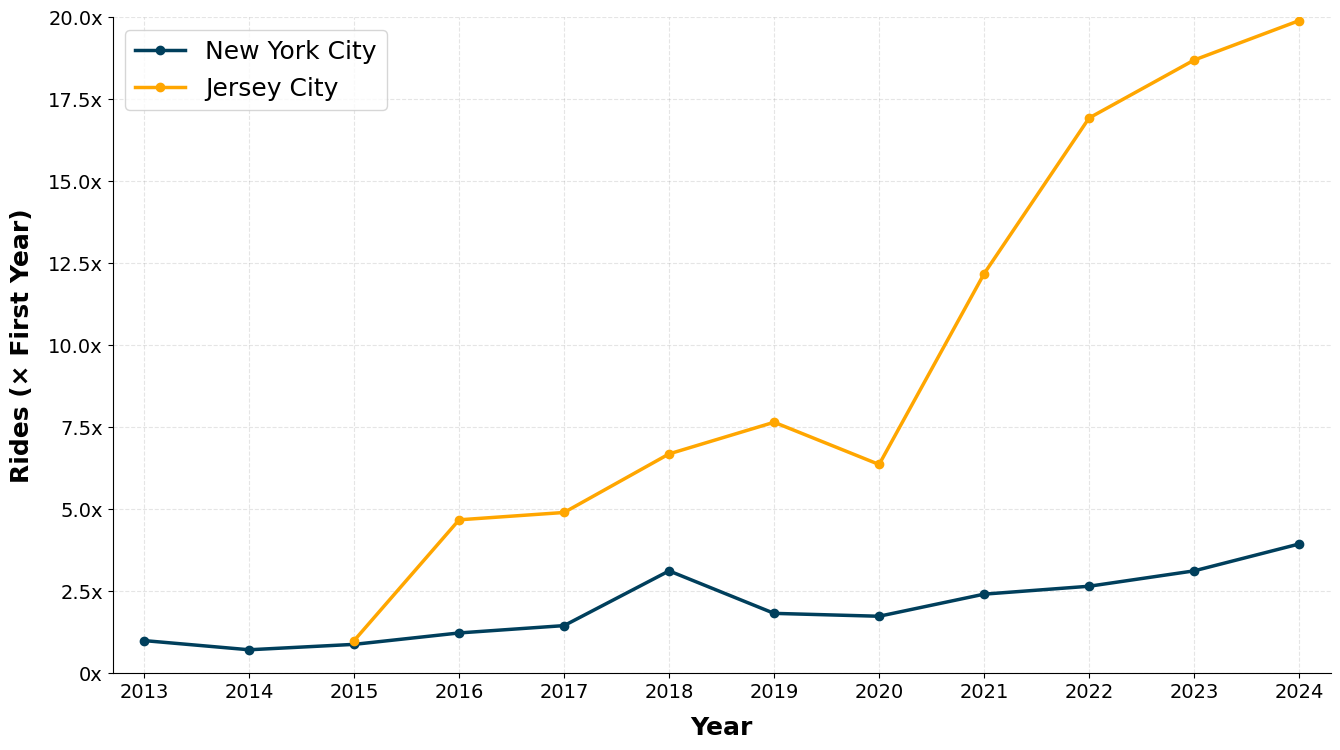

In [14]:
# import matplotlib.pyplot as plt
# nyc_growth = nyc_totals
# jc_growth = jc_totals
# plt.figure(figsize=(10, 6))
# plt.plot(range(2013, 2025), nyc_growth, marker='o', color='#1f77b4', label='New York City', linewidth=2)
# plt.plot(range(2015, 2025), jc_growth, marker='o', color='#ff7f0e', label='Jersey City', linewidth=2)
# plt.xlabel('Year', fontsize=14,labelpad=15)
# plt.ylabel('Rides (× First Year)', fontsize=14,labelpad=20)
# plt.title('NYC vs JC Trip Growth Over Time', fontsize=20, fontweight='bold', pad=20)
# plt.xlim(2012.5, 2024.5)
# plt.ylim(0, max(max(nyc_growth), max(jc_growth)) + 1)
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.legend(frameon=True, facecolor='#f0f0f0', edgecolor='#d0d0d0', fontsize=12)
# plt.xticks(range(2013, 2025))
# yticks = [0, 2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 17.5, 20.0]
# plt.yticks(yticks, [f'{y}x' for y in yticks])
# plt.tight_layout()
# plt.show()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Growth data for NYC and Jersey City
nyc_growth, jc_growth = nyc_totals, jc_totals

# Create DataFrame
df = pd.DataFrame({
    'year': list(range(2013, 2025)),
    'nyc_data': nyc_growth,
    'jc_data': [None, None] + jc_growth  # JC data starts later
})

# McKinsey-style colors
colors = {
    'NYC': '#003f5c',
    'JC': '#ffa600'
}

# Create figure
plt.figure(figsize=(14, 8))

# Plot lines with markers
plt.plot(df['year'], df['nyc_data'], label='New York City', color=colors['NYC'], linewidth=2.5, marker='o')
plt.plot(df['year'], df['jc_data'], label='Jersey City', color=colors['JC'], linewidth=2.5, marker='o')

# Axes labels and title
plt.xlabel('Year', fontsize=18, fontweight='bold', labelpad=10)
plt.ylabel('Rides (× First Year)', fontsize=18, fontweight='bold', labelpad=10)
# plt.title('Yearly Growth in Rides: NYC vs Jersey City', fontsize=16, fontweight='bold', pad=15)

# Ticks
plt.xticks(range(2013, 2025), fontsize=14)
yticks = [0, 2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 17.5, 20.0]
plt.yticks(yticks, [f'{y}x' for y in yticks], fontsize=14)

# Set exact axis limits to remove extra padding
plt.xlim(df['year'].min()-0.3, df['year'].max()+0.3)
plt.ylim(0, max(yticks))

# Remove top and right spines for cleaner look
sns.despine()

# Light gridlines
# plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.grid(linestyle='--', color='gray', alpha=0.2)

# Legend
plt.legend(fontsize=18, frameon=True)

# Adjust margins
plt.tight_layout()
plt.subplots_adjust(left=0.08, right=0.95, top=0.9, bottom=0.08)

# Show plot
plt.show()
# plt.savefig('citi_bike_growth.png', dpi=600, bbox_inches='tight')



In [22]:
# for dashboard high-level metrics [2013-2024]
# Metric	How to Compute / Notes
# Total rides	Count of all trips per city/year
summary_metrics = {}
total_rides_nyc,total_rides_jc = sum(raw_data_total_rides['nyc'].values()),sum(raw_data_total_rides['jc'].values())
total_rides_nyc = total_rides_nyc - raw_data_total_rides['nyc']['2025']
total_rides_jc = total_rides_jc - raw_data_total_rides['jc']['2025']
summary_metrics["raw_total_rides"] = {"nyc":total_rides_nyc,"jc":total_rides_jc}
# % trips JC/NYC	Ratio of JC trips to NYC trips, maybe annual and overall [done]
# % Members vs Casual	Count by user_type / total [done]
# Peak hour / start time distribution	Extract hour from start_time, count trips [done]

# Busiest month	Group by trip_date month, sum trips
# Average trip duration	Mean of trip_duration (seconds/minutes) [done]
# Unique stations	Count distinct start_station_id / end_station_id [done]
nyc_jc_trip_ratios = []
members_casual_count = defaultdict(tuple)
peak_start_times = {}
busiest_months = {}
avg_trip_durations = {}
unique_stations = set()
for year in nyc_year_range:
    nyc_count,jc_count = conn.execute(f'SELECT COUNT(*) FROM nyc_{year}').fetchall()[0][0],None
    mem_cas_na_count = conn.execute(f"SELECT COUNT(*) FROM nyc_{year} WHERE user_type == '';").fetchall()[0][0]
    member_count = conn.execute(f"SELECT COUNT(*) FROM nyc_{year} WHERE user_type == 'Subscriber' or user_type == '\"Subscriber\"' or user_type == 'member';").fetchall()[0][0]
    casual_count = conn.execute(f"SELECT COUNT(*) FROM nyc_{year} WHERE user_type == 'Customer' or user_type == '\"Customer\"' or user_type == 'casual';").fetchall()[0][0]
    assert nyc_count == mem_cas_na_count + member_count + casual_count
    members_casual_count[("nyc",str(year))] = {"members":member_count,"casual":casual_count}
    peak_start_times[("nyc",str(year))] = conn.execute(f"SELECT HOUR(start_time),COUNT(*) AS trips_within_the_hour FROM nyc_{year} GROUP BY HOUR(start_time) ORDER BY trips_within_the_hour DESC").fetchall()
    busiest_months[("nyc",str(year))] = conn.execute(f"SELECT EXTRACT(MONTH FROM trip_date) AS month,COUNT(*) AS trips_in_the_month FROM nyc_{year} GROUP BY month ORDER BY trips_in_the_month DESC;").fetchall()
    avg_trip_durations[("nyc",str(year))] = (conn.execute(f"SELECT AVG(trip_duration) FROM nyc_{year};").fetchall()[0][0],nyc_count)
    count_station_id_numeric,count_station_id_str = 0,0
    unique_station_id_queries = [conn.execute(f"SELECT DISTINCT start_station_id AS d_start_ids FROM nyc_{year} ORDER BY d_start_ids ASC").fetchall(),
                                 conn.execute(f"SELECT DISTINCT end_station_id AS d_end_ids FROM nyc_{year} ORDER BY d_end_ids ASC").fetchall()]
    for q_res in unique_station_id_queries:
        for s_id in q_res:
            station_id = s_id[0].strip().strip('"').strip("'")
            try:
                num = float(station_id)
                unique_stations.add(int(num))
                count_station_id_numeric += 1
            except ValueError:
                station_id_str_lst = station_id.split(".")
                if len(station_id_str_lst) > 1:
                    num = int(station_id_str_lst[0])
                    unique_stations.add(num)
                    count_station_id_numeric += 1
                else:
                    unique_stations.add(station_id)
                    count_station_id_str += 1
    if year in list(jc_year_range):
        jc_count = conn.execute(f'SELECT COUNT(*) FROM jc_{year}').fetchall()[0][0]
        mem_cas_na_count = conn.execute(f"SELECT COUNT(*) FROM jc_{year} WHERE user_type == '';").fetchall()[0][0]
        member_count = conn.execute(f"SELECT COUNT(*) FROM jc_{year} WHERE user_type == 'Subscriber' or user_type == '\"Subscriber\"' or user_type == 'member' or user_type == '\"member\"';").fetchall()[0][0]
        casual_count = conn.execute(f"SELECT COUNT(*) FROM jc_{year} WHERE user_type == 'Customer' or user_type == '\"Customer\"' or user_type == 'casual' or user_type == '\"casual\"';").fetchall()[0][0]
        assert jc_count == mem_cas_na_count + member_count + casual_count
        members_casual_count[("jc",str(year))] = {"members":member_count,"casual":casual_count}
        peak_start_times[("jc",str(year))] = conn.execute(f"SELECT HOUR(start_time),COUNT(*) AS trips_within_the_hour FROM jc_{year} GROUP BY HOUR(start_time) ORDER BY trips_within_the_hour DESC").fetchall()
        busiest_months[("jc",str(year))] = conn.execute(f"SELECT EXTRACT(MONTH FROM trip_date) AS month,COUNT(*) AS trips_in_the_month FROM jc_{year} GROUP BY month ORDER BY trips_in_the_month DESC;").fetchall()
        avg_trip_durations[("jc",str(year))] = (conn.execute(f"SELECT AVG(trip_duration) FROM jc_{year};").fetchall()[0][0],jc_count)
        unique_station_id_queries = [conn.execute(f"SELECT DISTINCT start_station_id AS d_start_ids FROM jc_{year} ORDER BY d_start_ids ASC").fetchall(),
                                     conn.execute(f"SELECT DISTINCT end_station_id AS d_end_ids FROM jc_{year} ORDER BY d_end_ids ASC").fetchall()]
        for q_res in unique_station_id_queries:
            for s_id in q_res:
                station_id = s_id[0].strip().strip('"').strip("'")
                try:
                    num = float(station_id)
                    unique_stations.add(int(num))
                    count_station_id_numeric += 1
                except ValueError:
                    station_id_str_lst = station_id.split(".")
                    if len(station_id_str_lst) > 1:
                        num = int(station_id_str_lst[0])
                        unique_stations.add(num)
                        count_station_id_numeric += 1
                    else:
                        unique_stations.add(station_id)
                        count_station_id_str += 1
    nyc_jc_trip_ratios.append((year,nyc_count,jc_count))
total_trips_nyc,total_trips_jc = 0,0
for _,nyc_count,jc_count in nyc_jc_trip_ratios:
    total_trips_nyc += nyc_count
    total_trips_jc += (jc_count if jc_count else 0)
total_trips_both = total_trips_nyc + total_trips_jc
summary_metrics["pct_trips_ratio"] = {"nyc":round(total_trips_nyc/total_trips_both,4),
                                      "jc": round(total_trips_jc/total_trips_both,4)}
sum_members,sum_casual = 0,0
for (_,year),v in members_casual_count.items():
    if year == "2025":
        continue
    sum_members += v['members']
    sum_casual += v['casual']
summary_metrics["members_casual_count"] = {"total_trips_members":sum_members,"total_trips_casual":sum_casual}
trips_by_month = defaultdict(int)
for k,v in busiest_months.items():
    for month,count in v:
        trips_by_month[month] += count

# months = list(trips_by_month.keys())
# counts = list(trips_by_month.values())
busiest_months_agg = defaultdict(int)
for _,v in busiest_months.items():
    for month,count in v:
        busiest_months_agg[str(month)] += count
summary_metrics["busiest_months"] = sorted(busiest_months_agg.items(),key=lambda e:e[1],reverse=True)

# compute weighted average for avg trip duration
weighted_avg_trip_duration = 0
total_rides_sub = sum([count for _,(_, count) in avg_trip_durations.items()])
for _,(avg, count_i) in avg_trip_durations.items():
    weighted_avg_trip_duration += avg * (count_i/total_rides_sub)
summary_metrics["avg_trip_duration"] = weighted_avg_trip_duration
summary_metrics["unique_stations_count"] = len(unique_stations)
for k,v in summary_metrics.items():
    print(k,v)

raw_total_rides {'nyc': 271049085, 'jc': 5236794}
pct_trips_ratio {'nyc': 0.9805, 'jc': 0.0195}
members_casual_count {'total_trips_members': 222873235, 'total_trips_casual': 47874359}
busiest_months [('9', 36549694), ('8', 36076740), ('7', 34558736), ('6', 34154086), ('10', 30030628), ('5', 29588405), ('4', 23094710), ('11', 21883063), ('3', 18403543), ('12', 15525754), ('1', 13637117), ('2', 13484190)]
avg_trip_duration 1039.7460899197492
unique_stations_count 2941


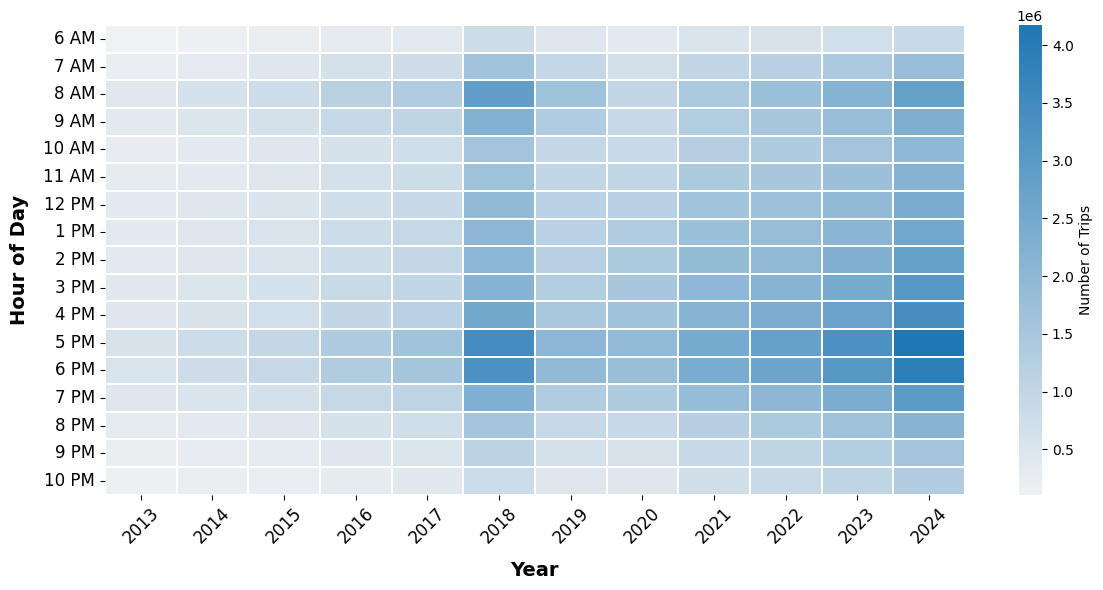

In [16]:
# peak start time analysis
'''
agg_peak_start_times = defaultdict(lambda:defaultdict(int)) # year -> {hh->count}
for (_,year),start_times in peak_start_times.items():
    for (hour,trips) in start_times:
        agg_peak_start_times[year][hour] += trips
df = pd.DataFrame.from_dict(agg_peak_start_times).sort_index(axis=0)
df = df.loc[6:22]
plt.figure(figsize=(10,6))
ax = sns.heatmap(data=df,annot=False,cmap='OrRd',linewidths=0.25)
plt.xticks(rotation=45)
plt.ylabel("Hour of Day", fontsize=14, fontweight='bold')
plt.xlabel("Year", fontsize=14, fontweight='bold')
hour_labels = [f"{h if h<=12 else h-12} {'AM' if h<12 else 'PM'}" for h in df.index]
ax.set_yticklabels(hour_labels, rotation=0, fontsize=12, fontweight='medium')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=12, fontweight='medium')
plt.tight_layout()
plt.show()
''' 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Aggregate peak start times
agg_peak_start_times = defaultdict(lambda: defaultdict(int))  # year -> {hour -> count}
for (_, year), start_times in peak_start_times.items():
    for hour, trips in start_times:
        agg_peak_start_times[year][hour] += trips

agg_peak_start_times.pop('2025')

# Convert to DataFrame
df = pd.DataFrame.from_dict(agg_peak_start_times).sort_index(axis=0)
df = df.loc[6:22]  # keep hours 6AM-10PM

# Set figure size
plt.figure(figsize=(12, 6))

# McKinsey-style color: muted orange-red (OrRd), subtle contrast
cmap = sns.light_palette("#1F77B4", as_cmap=True)  # muted, professional orange

# Plot heatmap
ax = sns.heatmap(
    data=df,
    annot=False,          # no numbers cluttering the cells
    cmap=cmap,
    linewidths=0.25,
    linecolor='white',    # subtle separation
    cbar_kws={'label': 'Number of Trips'}
)

# Axis labels
plt.xlabel("Year", fontsize=14, fontweight='bold', labelpad=10)
plt.ylabel("Hour of Day", fontsize=14, fontweight='bold', labelpad=10)

# Customize y-axis labels to AM/PM format
hour_labels = [f"{h if h <= 12 else h-12} {'AM' if h < 12 else 'PM'}" for h in df.index]
ax.set_yticklabels(hour_labels, rotation=0, fontsize=12, fontweight='medium')

# Customize x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=12, fontweight='medium')

# Minimalistic styling
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig('peak_trip_hours.png', dpi=600, bbox_inches='tight')



In [17]:
print('hello')

hello
